In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode,mean,median
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from math import radians, sin, cos, asin, sqrt
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import neighbors
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load the dataset used for the rfm and marketing analysis
sel_df1 = pd.read_csv("data__mktingstrategy.csv",sep = ",")
sel_df1 = sel_df1.drop(columns = ['Unnamed: 0'])

In [3]:
# transform dates into datetime object
sel_df1.ts_order_delivered_customer = pd.to_datetime(sel_df1.ts_order_delivered_customer)
sel_df1.ts_order_delivered_carrier = pd.to_datetime(sel_df1.ts_order_delivered_carrier)
sel_df1.ts_order_estimated_delivery = pd.to_datetime(sel_df1.ts_order_estimated_delivery)
sel_df1.ts_order_approved = pd.to_datetime(sel_df1.ts_order_approved)

In [4]:
# Add product volume, orders per day and difference between delivery and order approval as additional features
sel_df1['product_volume_cm3'] = sel_df1.product_length_cm * sel_df1.product_height_cm * sel_df1.product_width_cm
sel_df1['delivery_approved'] = (sel_df1.ts_order_delivered_customer-sel_df1.ts_order_approved).dt.days
trend= sel_df1.groupby(["hour_purch","order_id"], as_index=False)["order_id"].size()
trend= trend.groupby("hour_purch").hour_purch.value_counts().to_frame("Order per day")
trend= trend.reset_index(level=1, drop=True)


In [5]:
# Merging and Removal of dataset features
sel_df1= pd.merge(trend,sel_df1, on="hour_purch")
sel_df1=sel_df1.drop(['order_status','payment_installments_quantity','order_item_sequence_id'], axis=1, errors='ignore')
sel_df1=sel_df1.drop(['payment_method_sequence_id'], axis=1, errors='ignore')
sel_df1=sel_df1.drop(['transaction_value'], axis=1, errors='ignore')

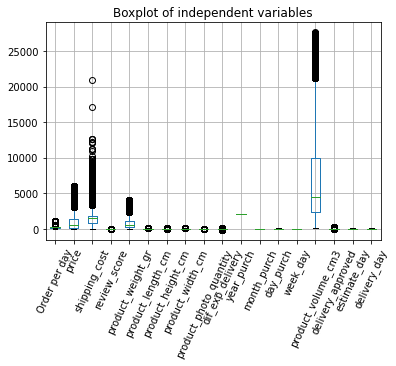

In [27]:
# Find and Remove outliers
sel_df1.boxplot()
plt.xticks(rotation = 65)
plt.title("Boxplot of independent variables")
plt.savefig("Boxplot of independent variables.png")

In [7]:
# Since there are many outliers, this function remove them 
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
# Remove outliers in the variables having the highest number of them
sel_df1= remove_outlier(sel_df1, "product_weight_gr")
sel_df1= remove_outlier(sel_df1, "product_volume_cm3")
sel_df1= remove_outlier(sel_df1, "price")

In [9]:
# Shipping cost into float
sel_df1["shipping_cost"]  = [float(str(i).replace(",", ".")) for i in sel_df1["shipping_cost"] ]


# Baseline

Before applying the models, set a baseline to compare results and verify the funcitoning of the new model, in this case the baseline will be the current delay in time shipping predictions.


In [10]:
# Extract the day of the estimated delivery and actual delivery
sel_df1["estimate_day"]=sel_df1.ts_order_estimated_delivery.dt.day
sel_df1["delivery_day"]= sel_df1.ts_order_delivered_customer.dt.day

In [11]:
# Compute the errors of the current data and use them as baseline model
baseline_data= {}
baseline_data["Test_RMSE"] = sqrt(mean_squared_error(sel_df1.delivery_day,sel_df1.estimate_day))
baseline_data["MAE"]= mean_absolute_error(sel_df1.delivery_day, sel_df1.estimate_day)
baseline_data

{'Test_RMSE': 13.412645103272611, 'MAE': 11.832532030790476}

<ipython-input-12-c117fc1e156e>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(sel_df1[sel_df1.columns[::-1]].corr(), dtype=np.bool)


Text(0.5, 1.0, 'Heatmap of all the Features')

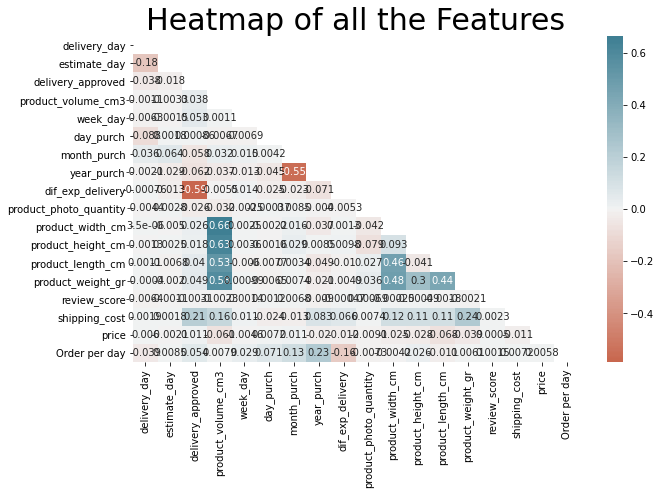

In [12]:
# Correlation plot of the variables
mask = np.zeros_like(sel_df1[sel_df1.columns[::-1]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 6))
sns.heatmap(sel_df1[sel_df1.columns[::-1]].corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, )
plt.title("Heatmap of all the Features", fontsize = 30)


# y as difference between delivery and approval

In [13]:
# Define target and feature variables, here the initial features 
#were chosen based on the possible influence on shipping
target = 'delivery_approved'
features = ['product_volume_cm3', 
            'product_weight_gr', 
            'day_purch',
            'shipping_cost',
            'price',
            'product_photo_quantity',
            'day_purch',
            'week_day',
            'Order per day'
           ]

In [14]:
# Extract target and features
X = sel_df1[features]
y = sel_df1[target]

In [15]:
X_data = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state = 14)

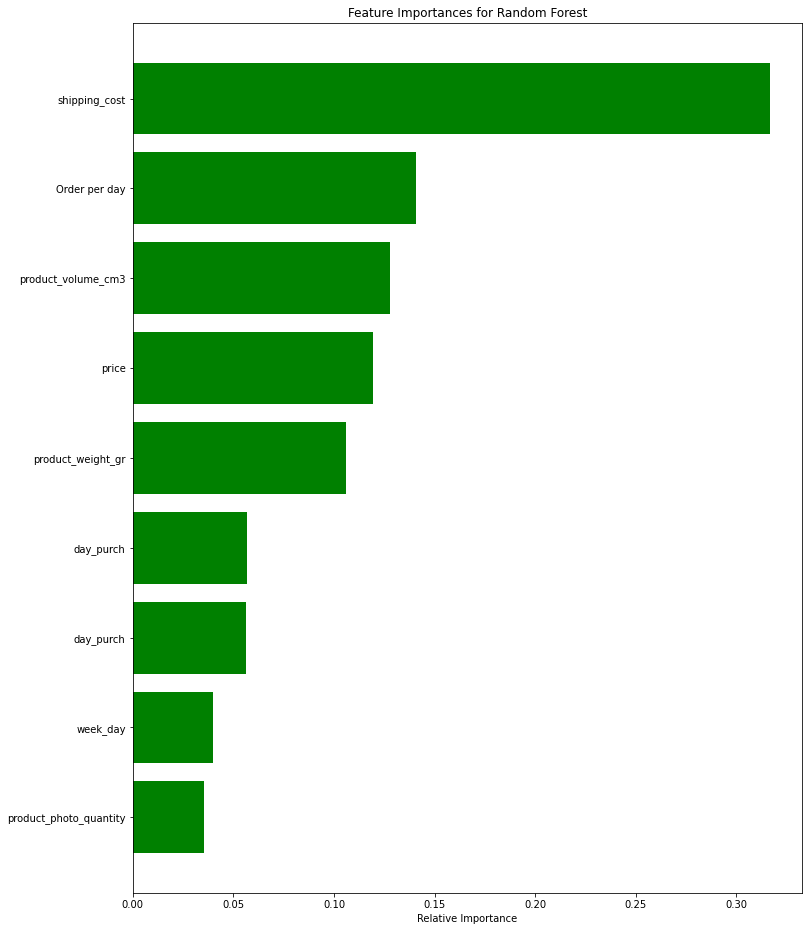

In [16]:
# we fit the model and compute feature importance to detect the most relevant variables to put in the model
features = X.columns
rf = RandomForestRegressor(n_estimators = 300,min_samples_split=8,max_features =4)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,16))
plt.title('Feature Importances for Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")

In [17]:
# Based on the results, two variables are removed: "week_day" and "product_photo_quantity"
target = 'delivery_approved'
features = ['product_volume_cm3', 
            'product_weight_gr', 
            'day_purch', 
            'shipping_cost',
            'price',
            'day_purch',
            'Order per day'
          ]

In [18]:
# Applying the models to the data 

models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] 
           #['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=10000,learning_rate_init=0.01,alpha=0.01)]
         ]

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 100
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    #curr_model_data["Train_Time"] = end - start
    curr_model_data["Test_RMSE"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    curr_model_data["MAE"] = mean_absolute_error(y_test, curr_model.predict(X_test))
    model_data.append(curr_model_data)

In [19]:
# See the results, the lowest MAE corresponds to the ExtraTreeRegressor algorithm 
# and means that the mean delay has been reduced to 4 days 
model_scores = pd.DataFrame(model_data)
model_scores

,Name,Train_Time,Test_RMSE,MAE
0,Lasso:,0.035828,8.614721,5.913926
1,Ridge:,0.026009,8.532818,5.851912
2,KNeighborsRegressor:,0.872210,8.218264,5.338767
3,RandomForest,46.848301,7.006637,4.346391
4,ExtraTreeRegressor :,20.206360,6.944978,4.091170
5,GradientBoostingRegressor:,10.997660,7.798285,5.116209


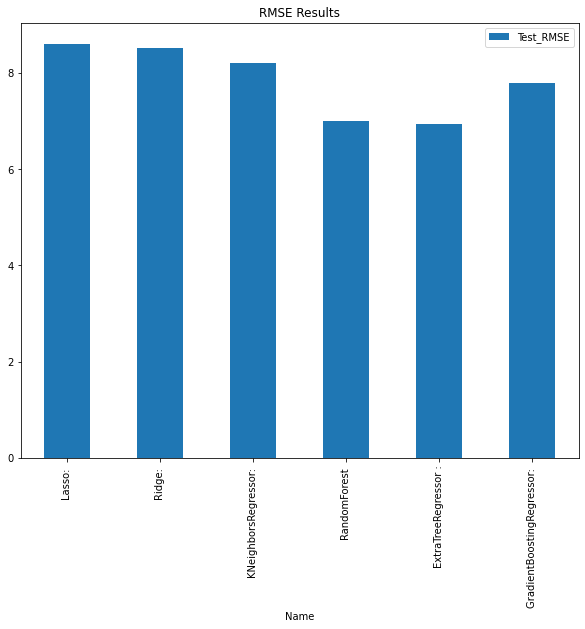

In [21]:
# Plotting RMSE results for all models
model_scores.plot(x = "Name", y = ['Test_RMSE'], kind = "bar" , title = 'RMSE Results' , figsize = (10,8))
plt.savefig("RMSE results.png")

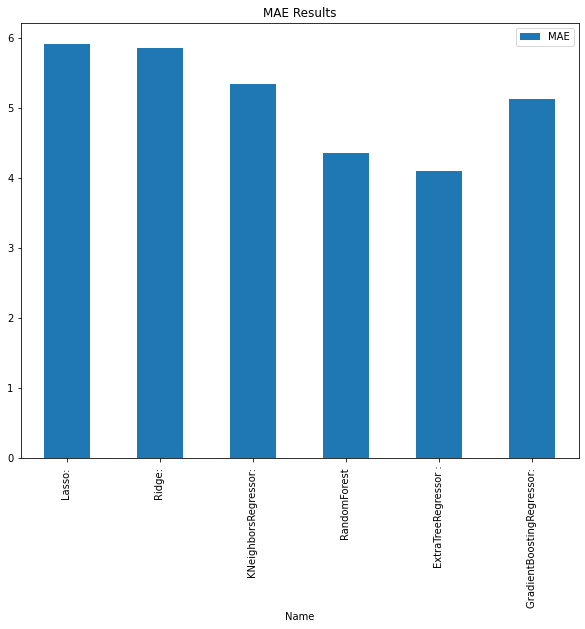

In [22]:
# Plotting MAE results for all models
model_scores.plot(x="Name", y=['MAE'], kind="bar" , title = 'MAE Results' , figsize= (10,8))
plt.savefig("MAE Results.png")